# Loading Data

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the data and preprocess it ---
data = pd.read_csv('../data/curated/rent.csv')

#Select the features
features = ['Year', 'Month', 'Bed', 'Apartment', 'postcode', 'tram_count', 
            'bus_count', 'school_total', 'park_count', 'mean_park_area', 
            '2025_x', '2025_y', '2026_x', '2026_y', '2027_x', '2027_y']
X = data[features]
y = data['Median']  # The target variable is the median rent

# Convert month and postcode into dummy variables
X = pd.get_dummies(X, columns=['Month', 'postcode'])



# Model

In [2]:

# Split the dataset into training and testing sets (used for calculating RMSE and R²)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regression model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set and calculate RMSE and R²
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE) on the test set: {rmse}")
print(f"R-squared (R²) on the test set: {r2}")



Root Mean Squared Error (RMSE) on the test set: 20.260404511205504
R-squared (R²) on the test set: 0.9833909273147583


# Feature Importance

<Figure size 1000x800 with 0 Axes>

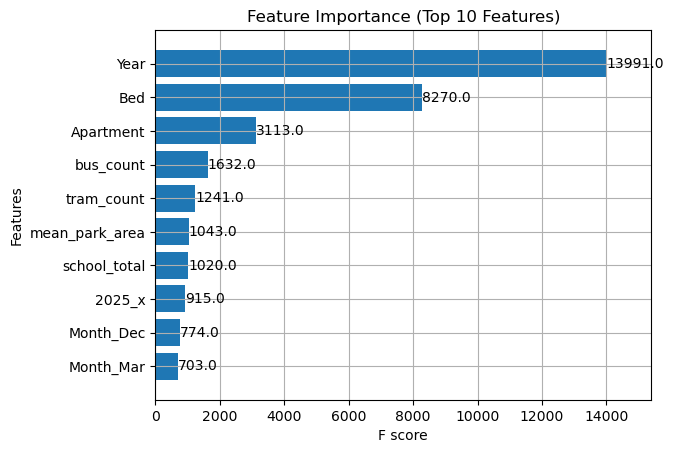

In [3]:
# --- Plot feature importance ---
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title('Feature Importance (Top 10 Features)')
plt.show()


#  Generating Future Predictions (2025-2027)

In [4]:
# --- Generate predictions for 2025-2027 ---
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = [2025, 2026, 2027]
postcodes = data['postcode'].unique()

# Create a DataFrame for future predictions
future_predictions = pd.DataFrame()

for postcode in postcodes:
    # Get the average number of beds and apartment type for each postcode
    bed_avg = data[data['postcode'] == postcode]['Bed'].mean()
    apartment_avg = data[data['postcode'] == postcode]['Apartment'].mean()

    future_data = pd.DataFrame({
        'Year': [year for year in years for _ in range(12)],
        'Month': months * len(years),
        'Bed': [bed_avg] * 12 * len(years),  # Use the average number of beds for the postcode
        'Apartment': [apartment_avg] * 12 * len(years),  # Use the average apartment type for the postcode
        'postcode': [postcode] * 12 * len(years),
        'tram_count': [data[data['postcode'] == postcode]['tram_count'].mean()] * 12 * len(years),
        'bus_count': [data[data['postcode'] == postcode]['bus_count'].mean()] * 12 * len(years),
        'school_total': [data[data['postcode'] == postcode]['school_total'].mean()] * 12 * len(years),
        'park_count': [data[data['postcode'] == postcode]['park_count'].mean()] * 12 * len(years),
        'mean_park_area': [data[data['postcode'] == postcode]['mean_park_area'].mean()] * 12 * len(years),
        '2025_x': [data[data['postcode'] == postcode]['2025_x'].mean()] * 12 * len(years),
        '2025_y': [data[data['postcode'] == postcode]['2025_y'].mean()] * 12 * len(years),
        '2026_x': [data[data['postcode'] == postcode]['2026_x'].mean()] * 12 * len(years),
        '2026_y': [data[data['postcode'] == postcode]['2026_y'].mean()] * 12 * len(years),
        '2027_x': [data[data['postcode'] == postcode]['2027_x'].mean()] * 12 * len(years),
        '2027_y': [data[data['postcode'] == postcode]['2027_y'].mean()] * 12 * len(years)
    })

    # Convert month and postcode into dummy variables
    future_data = pd.get_dummies(future_data, columns=['Month', 'postcode'])

    # Ensure future data has the same columns as the training data
    missing_cols = set(X_train.columns) - set(future_data.columns)
    for col in missing_cols:
        future_data[col] = 0

    future_data = future_data[X_train.columns]

    # Predict future rent
    future_preds = model.predict(future_data)

    # Store the prediction results
    prediction_df = pd.DataFrame({
        'Year': [year for year in years for _ in range(12)],
        'Month': months * len(years),
        'Postcode': [postcode] * 12 * len(years),
        'Predicted_Median_Rent': future_preds
    })

    future_predictions = pd.concat([future_predictions, prediction_df], ignore_index=True)


# Saving And Visualizing 

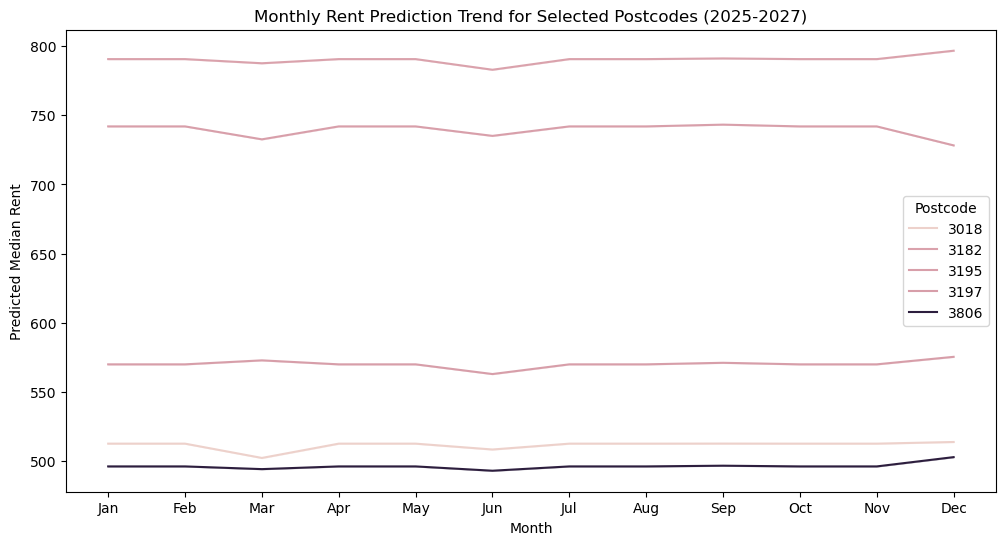

In [5]:
# --- Save predictions to CSV ---
future_predictions.to_csv('../data/curated/XGBoost_prediction_2025_2027.csv', index=False)


# --- Visualize the predicted rent data ---
plt.figure(figsize=(12, 6))
sample_predictions = future_predictions[future_predictions['Postcode'].isin(postcodes[:5])]  # Visualize for 5 postcodes
sns.lineplot(x='Month', y='Predicted_Median_Rent', hue='Postcode', data=sample_predictions)
plt.title('Monthly Rent Prediction Trend for Selected Postcodes (2025-2027)')
plt.xlabel('Month')
plt.ylabel('Predicted Median Rent')
plt.legend(title='Postcode')
plt.show()


# Cross-Validation

In [6]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)}")

Cross-Validation RMSE: 82.22979031626899


# Learning Curves

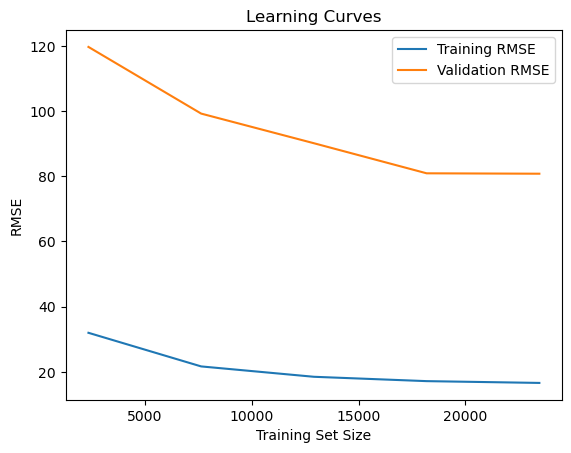

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training RMSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Residual Analysis on Validation Set

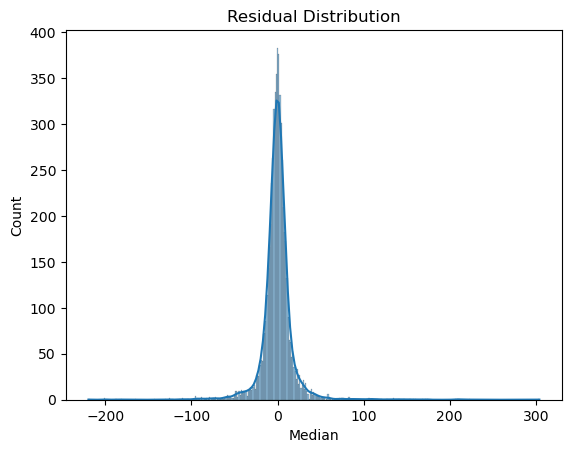

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

# SHAP Value Analysis

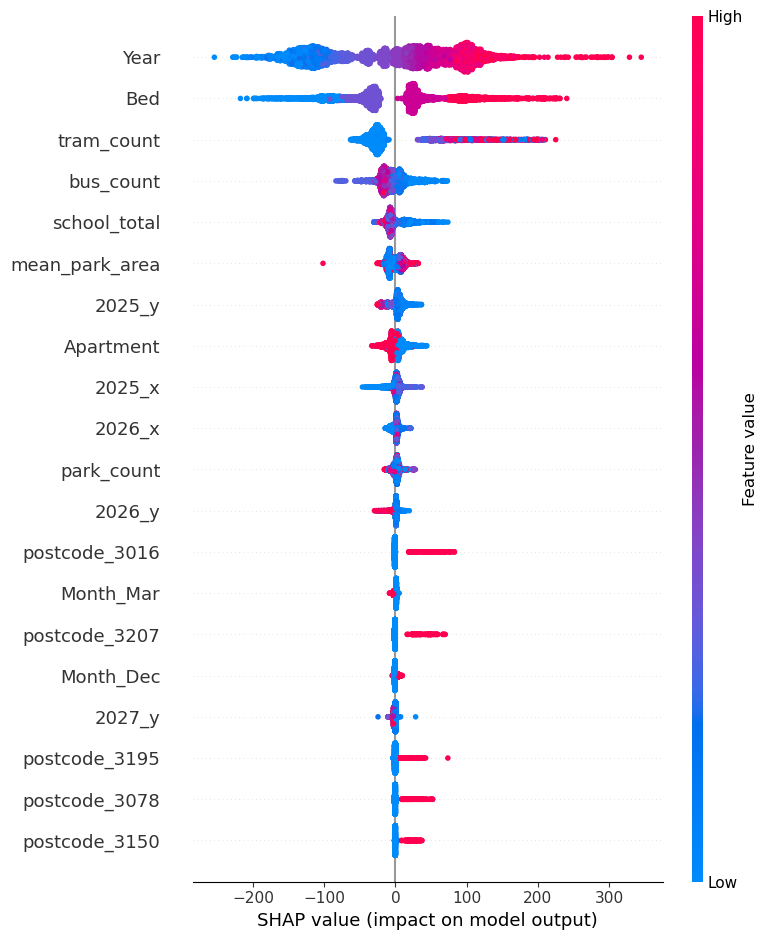

In [9]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)